# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

In [90]:
#!pip install -qU ragas==0.2.10

In [91]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [92]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

OPTIONALLY:

We can also provide a Ragas API key - which you can sign-up for [here](https://app.ragas.io/).

In [93]:
os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [94]:
!mkdir data

path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"

print(path)

C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data


A subdirectory or file data already exists.


In [95]:
!curl -k https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o "{path}/2023_llms.html"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 31427    0 31427    0     0  58969      0 --:--:-- --:--:-- --:--:-- 59633


In [96]:
!curl -k https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o "{path}/2024_llms.html"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 70286    0 70286    0     0   538k      0 --:--:-- --:--:-- --:--:--  558k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [97]:
from langchain_community.document_loaders import DirectoryLoader

path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()
print(docs)

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


[Document(metadata={'source': 'C:\\Users\\dabra\\OneDrive\\Documents\\AI Makerspace\\AIE5\\08_Evaluating_RAG_With_Ragas\\data\\2023_llms.html'}, page_content="Simon Willison’s Weblog\n\nSubscribe\n\nStuff we figured out about AI in 2023\n\n31st December 2023\n\n2023 was the breakthrough year for Large Language Models (LLMs). I think it’s OK to call these AI—they’re the latest and (currently) most interesting development in the academic field of Artificial Intelligence that dates back to the 1950s.\n\nHere’s my attempt to round up the highlights in one place!\n\nLarge Language Models\n\nThey’re actually quite easy to build\n\nYou can run LLMs on your own devices\n\nHobbyists can build their own fine-tuned models\n\nWe don’t yet know how to build GPT-4\n\nVibes Based Development\n\nLLMs are really smart, and also really, really dumb\n\nGullibility is the biggest unsolved problem\n\nCode may be the best application\n\nThe ethics of this space remain diabolically complex\n\nMy blog in 2023

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [98]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [ ]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:  46%|████▌     | 12/26 [00:06<00:10,  1.40it/s]unable to apply transformation: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:  50%|█████     | 13/26 [01:13<03:17, 15.19s/it]unable to apply transformation: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:  54%|█████▍    | 14/26 [01:32<03:1

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [11]:
print(dataset.to_pandas())

                                           user_input  \
0   What role has Meta played in the development o...   
1   Cud LLMs be more efective in Spanish than in o...   
2   Wht is the brekthrough abut Lrge Langage Modls...   
3   Wht iz the impct of DALL-E 3 on the artstc com...   
4   How have advancements in training costs and en...   
5   How have advancements in LLM technology impact...   
6   What are the challenges and implications of us...   
7   How do the ethics of training data impact the ...   
8   How does the fine-tuning process of Meta's Lla...   
9   What did we learn about LLMs in 2024 and how d...   
10  What advancements in GPT-4V and GPT-4 technolo...   
11  How does the development of Claude's character...   

                                   reference_contexts  \
0   [Code may be the best application The ethics o...   
1   [Based Development As a computer scientist and...   
2   [Simon Willison’s Weblog Subscribe Stuff we fi...   
3   [easy to follow. The rest 

#### OPTIONAL:

If you've provided your Ragas API key - you can use this web interface to look at the created data!

In [12]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/de1efd49-8b29-48fa-bef7-837d9064c40f


'https://app.ragas.io/dashboard/alignment/testset/de1efd49-8b29-48fa-bef7-837d9064c40f'

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [13]:
path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [14]:
docs

[Document(metadata={'source': 'C:\\Users\\dabra\\OneDrive\\Documents\\AI Makerspace\\AIE5\\08_Evaluating_RAG_With_Ragas\\data\\2023_llms.html'}, page_content="Simon Willison’s Weblog\n\nSubscribe\n\nStuff we figured out about AI in 2023\n\n31st December 2023\n\n2023 was the breakthrough year for Large Language Models (LLMs). I think it’s OK to call these AI—they’re the latest and (currently) most interesting development in the academic field of Artificial Intelligence that dates back to the 1950s.\n\nHere’s my attempt to round up the highlights in one place!\n\nLarge Language Models\n\nThey’re actually quite easy to build\n\nYou can run LLMs on your own devices\n\nHobbyists can build their own fine-tuned models\n\nWe don’t yet know how to build GPT-4\n\nVibes Based Development\n\nLLMs are really smart, and also really, really dumb\n\nGullibility is the biggest unsolved problem\n\nCode may be the best application\n\nThe ethics of this space remain diabolically complex\n\nMy blog in 2023

Now that we have our data loaded, let's split it into chunks!

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

74

#### ❓ Question: 

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

The `chunk_overlap` parameter indicates the number of characters overlapping between consecutive chunks. This means the first 200 characters of each chunk will contain the last 200 characters of the previous chunk.  This parameter is used to maintain context and retain information across the chunks.  

By preserving information between chunks, we can preserve semantic contexts, contextual relationships, and maintain coherence across sentences.  

While a larger overlap helps preserve the natural flow of information and reduces the risk of losing critical context at chunk boundaries, it also increases storage requirements, increases redundancy (leading to processing overheads when tasks use these chunks), and computational costs.

Like every other use case, it is critical to determine the correct value for each situation, input data, use case requirements, tech stack being used, and final application being built.

</span>
</div>

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [18]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [19]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [20]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [21]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [22]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [23]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [25]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [26]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [27]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's do a test to make sure it's doing what we'd expect.

In [28]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [29]:
response["response"]

'LLM agents are useful primarily because they can effectively generate code, which is one of their most capable applications. Despite concerns about their negative aspects and the skepticism surrounding them, the surprising ease with which they can be built and run has opened up their accessibility. As training an LLM has become feasible for more entities than just the super-rich, more people can experiment with and utilize these models.\n\nAdditionally, LLMs can be run on personal devices, making them more accessible for individuals to harness their capabilities without needing expensive hardware. Their effectiveness, particularly in areas like code generation, where they can execute and iterate on code to correct errors, showcases their potential utility. \n\nMoreover, there is a recognition that while LLMs are not without issues, such as hallucinations and ethical concerns, they still warrant discussion and responsible use. The ongoing dialogue about their impact suggests a need for

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [30]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [31]:
dataset.to_pandas()

user_input  \
0   What role has Meta played in the development o...   
1   Cud LLMs be more efective in Spanish than in o...   
2   Wht is the brekthrough abut Lrge Langage Modls...   
3   Wht iz the impct of DALL-E 3 on the artstc com...   
4   How have advancements in training costs and en...   
5   How have advancements in LLM technology impact...   
6   What are the challenges and implications of us...   
7   How do the ethics of training data impact the ...   
8   How does the fine-tuning process of Meta's Lla...   
9   What did we learn about LLMs in 2024 and how d...   
10  What advancements in GPT-4V and GPT-4 technolo...   
11  How does the development of Claude's character...   

                                   retrieved_contexts  \
0   [I wrote about how Large language models are h...   
1   [So training an LLM still isn’t something a ho...   
2   [Code may be the best application\n\nThe ethic...   
3   [Law is not ethics. Is it OK to train models o...   
4   [If you can gather the right data, and afford ...   
5   [So training an LLM still isn’t something a ho...   
6   [Another common technique is to use larger mod...   
7   [Since then, almost every major LLM (and most ...   
8   [Another common technique is to use larger mod...   
9   [This is Things we learned about LLMs in 2024 ...   
10  [Training a GPT-4 beating model was a huge dea...   
11  [Still, I’m surprised that no-one has beaten t...   

                                   reference_contexts  \
0   [Code may be the best application The ethics o...   
1   [Based Development As a computer scientist and...   
2   [Simon Willison’s Weblog Subscribe Stuff we fi...   
3   [easy to follow. The rest of the document incl...   
4   [<1-hop>\n\nCode may be the best application T...   
5   [<1-hop>\n\nCode may be the best application T...   
6   [<1-hop>\n\nCode may be the best application T...   
7   [<1-hop>\n\nCode may be the best application T...   
8   [<1-hop>\n\nAnother common technique is to use...   
9   [<1-hop>\n\nSimon Willison’s Weblog Subscribe ...   
10  [<1-hop>\n\nfeed with the model and talk about...   
11  [<1-hop>\n\nAnother common technique is to use...   

                                             response  \
0   Meta has played a significant role in the deve...   
1   The provided context does not specifically add...   
2   The breakthrough regarding Large Language Mode...   
3   The impact of DALL-E 3 on the artistic communi...   
4   Advancements in training costs and environment...   
5   Advancements in LLM technology have led to a r...   
6   Using Large Language Models (LLMs) as black bo...   
7   The ethics of training data significantly affe...   
8   The fine-tuning process of Meta's Llama 3.3 us...   
9   In 2024, we learned several key advancements a...   
10  Recent advancements in GPT-4V and GPT-4 techno...   
11  The development of Claude's character by Anthr...   

                                            reference  \
0   Meta released Llama, which allowed Large Langu...   
1   The context suggests that LLMs are particularl...   
2   2023 was the breakthrough year for Large Langu...   
3   The context does not provide specific informat...   
4   Advancements in training costs and environment...   
5   Advancements in LLM technology have significan...   
6   The use of Large Language Models (LLMs) as bla...   
7   The ethics of training data significantly impa...   
8   The fine-tuning process of Meta's Llama 3.3, w...   
9   In 2024, significant advancements were made in...   
10  Recent advancements in GPT-4V and GPT-4 techno...   
11  The development of Claude's character by Anthr...   

                        synthesizer_name  
0   single_hop_specifc_query_synthesizer  
1   single_hop_specifc_query_synthesizer  
2   single_hop_specifc_query_synthesizer  
3   single_hop_specifc_query_synthesizer  
4   multi_hop_abstract_query_synthesizer  
5   multi_hop_abstract_query_synthesizer  
6   multi_hop_abstract_query_syn

Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [32]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [33]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

Next up - we simply evaluate on our desired metrics!

In [34]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 72/72 [05:52<00:00,  4.90s/it]


{'context_recall': 0.6256, 'faithfulness': 0.7963, 'factual_correctness': 0.4592, 'answer_relevancy': 0.8604, 'context_entity_recall': 0.3991, 'noise_sensitivity_relevant': 0.2248}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

In [35]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")


We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [36]:
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [37]:
!pip install -qU cohere langchain_cohere


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [ ]:
import sys
import subprocess

print(f"Using Python: {sys.executable}")
subprocess.check_call([sys.executable, "-m", "pip", "install", "langchain-cohere"])

Using Python: c:\Users\dabra\AppData\Local\Programs\Python\Python39\python.exe


0

In [ ]:
import langchain_cohere
from langchain_cohere import CohereRerank

In [ ]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

# def retrieve_adjusted(state):
#   compressor = CohereRerank(model="rerank-v3.5")
#   compression_retriever = ContextualCompressionRetriever(
#     base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
#   )
#   retrieved_docs = compression_retriever.invoke(state["question"])
#   return {"context" : retrieved_docs}

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5", top_n = 5)
  compression_retriever = ContextualCompressionRetriever(
    # base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
    base_compressor=compressor, base_retriever=retriever
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [44]:
class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

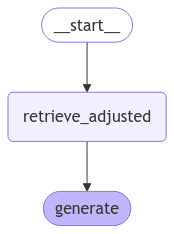

In [66]:
graph

In [45]:
response = graph.invoke({"question" : "How are LLM agents useful?"})
response["response"]

'LLM agents can be useful primarily in writing code, as they demonstrate significant effectiveness in generating programming languages like Python and JavaScript. The simplicity and clarity of programming grammar make it easier for LLMs to produce accurate code. Additionally, they can execute the generated code and iteratively improve it by processing error messages, addressing one of the major issues of hallucinations—providing incorrect or non-existent methods—which is less of a concern in code generation.\n\nHowever, there is skepticism surrounding the broader utility of LLM agents, particularly in making meaningful decisions due to their gullibility. LLMs can be easily misled, which raises concerns about their reliability, especially if tasked with responsibility, like in digital assistant roles or as travel agents. Additionally, the lack of functioning examples of LLM agents in production raises questions about their practical applications.\n\nDespite their potential, it is essent

In [49]:
print(type(dataset))

<class 'ragas.testset.synthesizers.testset_schema.Testset'>


In [86]:
eval_ds_pandas = dataset.to_pandas()

print(eval_ds_pandas.columns)

eval_ds_pandas = eval_ds_pandas[['user_input', 'reference_contexts', 'reference', 'synthesizer_name']]

print(eval_ds_pandas.columns)

Index(['user_input', 'retrieved_contexts', 'reference_contexts', 'response',
       'reference', 'synthesizer_name'],
      dtype='object')
Index(['user_input', 'reference_contexts', 'reference', 'synthesizer_name'], dtype='object')


In [87]:
print(test_row.__dict__) 

{'user_input': "How does the development of Claude's character by Anthropic relate to the challenges of using LLMs effectively?", 'retrieved_contexts': None, 'reference_contexts': ['<1-hop>\n\nAnother common technique is to use larger models to help create training data for their smaller, cheaper alternatives—a trick used by an increasing number of labs. DeepSeek v3 used “reasoning” data created by DeepSeek-R1. Meta’s Llama 3.3 70B fine-tuning used over 25M synthetically generated examples. Careful design of the training data that goes into an LLM appears to be the entire game for creating these models. The days of just grabbing a full scrape of the web and indiscriminately dumping it into a training run are long gone. LLMs somehow got even harder to use A drum I’ve been banging for a while is that LLMs are power-user tools—they’re chainsaws disguised as kitchen knives. They look deceptively simple to use—how hard can it be to type messages to a chatbot?—but in reality you need a huge 

In [88]:
evaluation_dataset_updated = EvaluationDataset.from_pandas(eval_ds_pandas)

for test_row in evaluation_dataset_updated:
    response = graph.invoke({"question": test_row.user_input})  # Adjusted
    test_row.response = response["response"]
    test_row.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)

# for test_row in evaluation_dataset_updated:
#   response = graph.invoke({"question" : test_row.eval_sample.user_input})
#   test_row.eval_sample.response = response["response"]
#   test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
#   time.sleep(2) # To try to avoid rate limiting.

In [ ]:
result = evaluate(
    dataset=evaluation_dataset_updated,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 72/72 [07:05<00:00,  5.91s/it]


{'context_recall': 0.7958, 'faithfulness': 0.7705, 'factual_correctness': 0.4125, 'answer_relevancy': 0.8633, 'context_entity_recall': 0.5233, 'noise_sensitivity_relevant': 0.2863}

#### ❓ Question: 

Which system performed better, on what metrics, and why?

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

RAG System 1 uses a retriever extracting 5 documents (k = 5). RAG System 2 uses a retriever extracting 5 documents (k = 20).  
The comparison of these 2 RAG pipelines (tabulating the performance results printed above) shows the classic trade-off between recall and noise in action.    

|            Metric            |                                                                         Definition                                                                        | RAG System 1 (k=5) | RAG System 2 (k=20) |    Higher is Better?   | Which System is Better? |
|:----------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------:|:------------------:|:-------------------:|:----------------------:|:-----------------------:|
| Context   Recall             | Measures # of relevant documents retrieved from the knowledge base.                     | 0.6256             | 0.7958              | ✅ Yes                  | RAG System 2            |
| Faithfulness                 | Assesses whether the responses are grounded in the retrieved documents.                                                | 0.7963             | 0.7705              | ✅ Yes                  | RAG System 1            |
| Factual   Correctness        | Evaluates if the response is factually accurate based on external knowledge, even if not present in the retrieved documents.           | 0.4592             | 0.4125              | ✅ Yes                  | RAG System 1            |
| Answer   Relevancy           | Measures how well the response addresses the query - an indicator of contextual relevance.                 | 0.8604             | 0.8633              | ✅ Yes                  | RAG System 2            |
| Context   Entity Recall      | Measures how many key entities from the ground truth context appear in the retrieved documents.        | 0.3991             | 0.5233              | ✅ Yes                  | RAG System 2            |
| Noise   Sensitivity Relevant | Measures the system’s sensitivity to noise / irrelevant information. | 0.2248             | 0.2863              | ❌ No (Lower is Better) | RAG System 1            |


Increasing k (more retrieved documents), as shown in RAG system 2 (k=20), improves recall but introduces more noise.
-  System 2 retrieves more relevant information (higher context recall, entity recall).  
-  But it struggles with faithfulness and factual correctness because it has to filter through more documents, increasing irrelevant or contradictory content.  

RAG System 1 (k=5) retrieves fewer but more relevant documents, leading to better factual correctness and faithfulness.  
-  Lower noise sensitivity means it is more robust to irrelevant data.  
-  More factually correct responses because it works with fewer, more precise sources.

Depending on the business objective and use case goals, we can choose either of the systems.  

1. If precision and factual correctness are more important (e.g., medical, legal domain), RAG System 1 (k=5) is better.  
2. If higher recall and broad knowledge retrieval are required (e.g., research, exploratory Q&A), RAG System 2 (k=20) is better.
</span>
</div>